In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import itertools
import MetaTrader5 as mt5
import pytz
import matplotlib as py
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import arch
import math

## Connect to MetaTrader5

In [2]:
initilized = mt5.initialize()

if initilized:
    print('Connected to MetaTrader5')
    print('Login:', mt5.account_info().login)
    print('Server:', mt5.account_info().server)

Connected to MetaTrader5
Login: 30668876
Server: GrowthNext-Demo


## Setting parameters and retrieving data

In [3]:
sym = "XAUUSD"
timeframes = mt5.TIMEFRAME_M10
gmt_now = datetime.now(pytz.timezone('Etc/GMT'))
lot_size = 0.1

In [108]:
#testing for 365 days which is 
raw = pd.DataFrame(mt5.copy_rates_from(sym, timeframes, gmt_now, 1000))
raw['time'] = pd.to_datetime(raw['time'], unit='s', errors='coerce')
#raw.drop(columns=['tick_volume', 'real_volume', 'high', 'low'], inplace=True)
#raw.set_index('time', inplace=True)

## Applying returns

In [109]:
monte_ret = raw.copy()
monte_ret["pips"] = (monte_ret["close"] - monte_ret["close"].shift(1))
monte_ret = monte_ret.dropna()

# Percentage Returns
monte_ret["pct_returns"] = monte_ret["close"].pct_change().dropna()
monte_ret = monte_ret.dropna()

# Sort returns in ascending order
monte_ret_var = monte_ret.pct_returns

# Predicting volatility at time t+1 for monte carlo simulation
df = pd.DataFrame(monte_ret, columns=['pct_returns'])

# Rescale the returns data
df['scaled_returns'] = df['pct_returns'] * 10000


# GARCH(1,1) with rolling window = 2

rolling_window = 2
forecasts_variance = []  # Use forecasts_variance list to store the predicted variances
forecasts_mean = []  # Use forecasts_mean list to store the predicted means

for i in range(len(df['scaled_returns']) - rolling_window + 1):  # Note the +1 to ensure inclusive window

    # Slice the rescaled returns for the current rolling window
    windowed_returns = df['scaled_returns'].iloc[i : i + rolling_window]

    # Fit GARCH(1,1) model for the current window
    model = arch.arch_model(windowed_returns, vol='Garch', p=1, q=1)
    results = model.fit()

    # Forecast volatility and mean for the next time step
    forecast = results.forecast(horizon=1)
    forecast_variance = np.sqrt(forecast.variance.values[-1, -1]) / 10000  # Convert back to original scale
    forecast_mean = forecast.mean.values[-1, -1] / 10000  # Convert back to original scale

    forecasts_variance.append(forecast_variance)
    forecasts_mean.append(forecast_mean)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.492613235821335
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.492613235821334
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2.9608636319696937
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.9608636319696937
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2.681323619800251
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.681323619800251
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.3540352723714326
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0342. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarni

Iteration:      1,   Func. Count:      5,   Neg. LLF: -0.541970269296147
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5419702692961472
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1.924632638665941
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.9246326386659416
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2.519581509741915
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.519581509741914
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.473671772421374
Optimization terminated successfully    (Exit mode 0)
            Current function value

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008531. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.319e-10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+05 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:766: Converg

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.52203485212992
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.52203485212992
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 0.9557091371858317
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9557091371858317
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1.3824108304287461
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.382410830428746
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 6.380579199413718
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.3

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04286. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02612. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarn

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.550083929720516
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.5500839297205156
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 6.145788002370807
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.145788002370807
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.1183222914251445
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1183222914251445
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.877250081436017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002073. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWar

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.9567521584425815
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.9567521584425815
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 6.015725906841769
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.015725906841769
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.0279551907568907
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.0279551907568907
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 6.0641333790832
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008498. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02597. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 2.2823474335687557
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.282347433568755
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2.0230081267825564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.023008126782556
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.374897202320893
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.374897202320893
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2.397294474763036
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.185858571178323
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.185858571178322
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.935882798689869
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.935882798689869
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.63978049358092
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.63978049358092
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.324020117756522
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.3240

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04181. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWar

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.6514936291220925
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.6514936291220925
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.76973704919803
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.76973704919803
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.593757597973591
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.593757597973591
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1.9386644217249365
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07479. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0629. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 8.156760100847812
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.156760100847812
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.193546223041826
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.193546223041826
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.959127399823476
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.9591273998234757
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 6.226166252608817
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.2

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.984831741138162
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.984831741138162
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.294655482006998
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.2946554820069975
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.523566726172968
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.523566726172968
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.964156110660185
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.9

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05089. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07195. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarn

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2.643757620047788
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.6437576200477872
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 7.033536170583938
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.033536170583938
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.458140817261119
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.458140817261119
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.4244287451009034
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09559. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWar

Iteration:      1,   Func. Count:      5,   Neg. LLF: 8.51836825405402
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.51836825405402
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 7.407105290160621
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.4071052901606205
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.762630821111957
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.762630821111957
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 7.597988785561003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.597

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.241997315597143
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.241997315597143
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.5848494238528605
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.5848494238528605
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.548807332604326
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.548807332604326
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.4393923215922895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0501. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarni

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.801750950701871
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.801750950701871
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.469168618896141
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.4691686188961395
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 6.356306572609348
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.356306572609348
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 8.154178659595994
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.1

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03956. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0494. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.773574598168606
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.773574598168606
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.154728770718716
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.154728770718716
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.756277913169999
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.756277913169999
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2.871220352333446
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.87

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06949. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.658e-10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+05 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:766: Converge

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.957935526356709
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.9579355263567084
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.170860081206968
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.170860081206968
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1.547266306246088
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5472663062460879
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 6.227389722588217
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.909432245865949
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.909432245865949
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 6.290589447570694
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.290589447570694
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.012306850972299
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.012306850972299
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 7.55320997003097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.553

C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009631. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03003. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWar

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2.9571498468775554
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.957149846877555
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 6.049640991599297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.049640991599297
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -0.20876841105941757
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.208768411059418
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4.932479494731153
Optimization terminated successfully    (Exit mode 0)
            Current function value:

# Monte Carlo

In [111]:
# Number of simulations
num_simulations = 200000

# Initialize arrays to store VaR results
var_95_mean = []
var_95_variance = []

# Perform Monte Carlo simulation and calculate 95% VaR for each forecasted mean and variance
for mean, variance in zip(monte_ret_var.shift(1), forecasts_variance):
    # Generate simulated returns for the current forecasted mean and variance
    simulated_returns = np.random.normal(mean, np.sqrt(variance), num_simulations)
    
    # Calculate the 95% VaR for the simulated return series
    var_95 = np.percentile(simulated_returns, 0.01)
    
    # Append VaR results to the arrays
    var_95_mean.append(var_95)

    # Store the VaR results for each forecasted mean
    print(f"VaR (95%) for forecasted mean={mean} and variance={variance}: {var_95}")

VaR (95%) for forecasted mean=nan and variance=0.00022872908555182647: nan
VaR (95%) for forecasted mean=-0.000508315580796892 and variance=0.00010634233532563764: -0.03831685093682245
VaR (95%) for forecasted mean=-5.085740969323904e-05 and variance=9.247085027425106e-05: -0.03557051501770565
VaR (95%) for forecasted mean=0.00016182726095803623 and variance=0.00012944412087328994: -0.04235383756933039
VaR (95%) for forecasted mean=-2.3114439590465885e-05 and variance=0.000309788248353704: -0.06448084339698269
VaR (95%) for forecasted mean=-0.00028200268133704576 and variance=8.326624866750176e-05: -0.033915085513242335
VaR (95%) for forecasted mean=0.00033757381537036224 and variance=0.00017099744284077012: -0.04746933904274607
VaR (95%) for forecasted mean=0.00017104131803535871 and variance=0.00042513269048505276: -0.07606415453483323
VaR (95%) for forecasted mean=0.000513036203716899 and variance=0.0003280437858890206: -0.06548742080761137
VaR (95%) for forecasted mean=-0.000337229

VaR (95%) for forecasted mean=-0.0002803437657981078 and variance=0.0005675933648274789: -0.0910678157984108
VaR (95%) for forecasted mean=0.000399946673776741 and variance=0.000340028239255441: -0.06602148981561665
VaR (95%) for forecasted mean=-0.0007352400558782168 and variance=1.5226976346483265e-09: -0.0008825806341255098
VaR (95%) for forecasted mean=-5.518357736733481e-05 and variance=0.00023225804444493292: -0.05735643406674679
VaR (95%) for forecasted mean=-5.518662276260411e-05 and variance=0.0013020980070623245: -0.13494867127077792
VaR (95%) for forecasted mean=-0.00051970271165247 and variance=0.0012465888072524245: -0.1311224315201066
VaR (95%) for forecasted mean=0.002084493302472179 and variance=0.00028932812184739864: -0.060368309226758676
VaR (95%) for forecasted mean=-0.00040868431203266997 and variance=0.00011481193973583714: -0.040517394432939016
VaR (95%) for forecasted mean=0.00016997193166212732 and variance=5.042362083029771e-05: -0.025911516312954117
VaR (95%)

VaR (95%) for forecasted mean=4.601869279197146e-06 and variance=0.0004716690378629984: -0.08053707060869576
VaR (95%) for forecasted mean=4.14166329198995e-05 and variance=5.564995956275355e-05: -0.027740253172631218
VaR (95%) for forecasted mean=0.0009847547086458963 and variance=8.076070405627081e-05: -0.032606605104841424
VaR (95%) for forecasted mean=0.0008734547895203892 and variance=0.0005693947585602155: -0.08759068074350747
VaR (95%) for forecasted mean=0.0007119333814078477 and variance=0.00033051924744664785: -0.06709693529538864
VaR (95%) for forecasted mean=-0.0004268561357125833 and variance=0.00033968704195852517: -0.0683762145087962
VaR (95%) for forecasted mean=0.0002341823591807124 and variance=0.000222030560769082: -0.055084720911860806
VaR (95%) for forecasted mean=0.0009135564430977627 and variance=0.00025741865292372434: -0.058505812308573095
VaR (95%) for forecasted mean=0.0013576175646359268 and variance=2.710398297645078e-05: -0.017956634097649367
VaR (95%) for

VaR (95%) for forecasted mean=0.001075135425712359 and variance=0.0002661649769840069: -0.05860038745476308
VaR (95%) for forecasted mean=0.0002570210344179369 and variance=3.4385183991014756e-05: -0.0218326134775039
VaR (95%) for forecasted mean=-0.00027530891955007686 and variance=3.2156189712362344e-05: -0.02106364283476961
VaR (95%) for forecasted mean=-0.00020653855156804735 and variance=0.00018593677773426354: -0.05097993556767142
VaR (95%) for forecasted mean=-0.000270850930992772 and variance=0.00025252594757074753: -0.05648166466193901
VaR (95%) for forecasted mean=0.00010102262447575505 and variance=0.0002479729492825822: -0.05746066590587001
VaR (95%) for forecasted mean=0.0006060745196172501 and variance=0.0003005323285668604: -0.06362738472197009
VaR (95%) for forecasted mean=0.00011012862105208576 and variance=0.00029366764713323334: -0.062245224674730384
VaR (95%) for forecasted mean=-0.000490936036081635 and variance=0.00011016460740465028: -0.03999906961207463
VaR (95%

VaR (95%) for forecasted mean=-0.00023236741388743543 and variance=0.0007088891279595223: -0.10108071636808735
VaR (95%) for forecasted mean=-0.0009068992703789025 and variance=0.00035118039054615746: -0.07273860635833967
VaR (95%) for forecasted mean=0.0005108789855401419 and variance=0.0001436571870392922: -0.04455767658199281
VaR (95%) for forecasted mean=-0.00019148179555217304 and variance=7.082796961099813e-05: -0.03110548908474562
VaR (95%) for forecasted mean=-0.00047879616963075744 and variance=0.0007324867239263955: -0.10228283761674262
VaR (95%) for forecasted mean=-0.0006204521088527537 and variance=0.0006252308762103032: -0.09332191904523393
VaR (95%) for forecasted mean=0.0008445213390000372 and variance=0.0002531629926380563: -0.058493418955988856
VaR (95%) for forecasted mean=-0.0004059404134205691 and variance=8.213044361993217e-05: -0.03331893295943629
VaR (95%) for forecasted mean=0.00010038557185554353 and variance=9.581705339301028e-05: -0.0366342774754682
VaR (95%

VaR (95%) for forecasted mean=0.0014034296028881954 and variance=0.0021158517042267344: -0.16740016301750624
VaR (95%) for forecasted mean=0.002613660431434184 and variance=0.0005974346321050984: -0.08820301666180422
VaR (95%) for forecasted mean=-0.001618042977019285 and variance=0.0007903192298378547: -0.1062361915974958
VaR (95%) for forecasted mean=-0.00042317371280908844 and variance=0.0014896881347224447: -0.14555399608108868
VaR (95%) for forecasted mean=0.001157464746866621 and variance=0.0006811111092333567: -0.09441532186833555
VaR (95%) for forecasted mean=-0.0018219115225782678 and variance=0.0004823391625545792: -0.08220964432874821
VaR (95%) for forecasted mean=-0.0004596893041115546 and variance=0.00020717407746251304: -0.05328508004003578
VaR (95%) for forecasted mean=0.0005049890209976038 and variance=0.00023229660289136866: -0.05646204253853185
VaR (95%) for forecasted mean=0.0009193371759226299 and variance=0.00017561774122198948: -0.04825188740937754
VaR (95%) for f

VaR (95%) for forecasted mean=0.00020899013299779945 and variance=0.00031330553896569135: -0.06608540289698527
VaR (95%) for forecasted mean=-0.0008846882251999366 and variance=0.00033383990741214786: -0.06788975848725781
VaR (95%) for forecasted mean=-0.0002580771472685539 and variance=0.0007969943880820063: -0.10486373295310025
VaR (95%) for forecasted mean=-0.0009257569620928496 and variance=0.00014223780562960808: -0.04424392853267764
VaR (95%) for forecasted mean=0.0006682318140711629 and variance=0.00010406676972873896: -0.03632547018572144
VaR (95%) for forecasted mean=0.0009527074253303791 and variance=0.0007225807859061462: -0.09976833933567336
VaR (95%) for forecasted mean=0.001160840964787857 and variance=0.0006354190999606768: -0.09217043289391917
VaR (95%) for forecasted mean=-0.0002843206070244353 and variance=0.0002015062708528026: -0.05287459147576376
VaR (95%) for forecasted mean=0.0009865175928969183 and variance=0.0007413140168466281: -0.09952181702390286
VaR (95%) f

VaR (95%) for forecasted mean=0.0002972532908600556 and variance=0.0005875167509404311: -0.08822946397344146
VaR (95%) for forecasted mean=0.0004302238938367342 and variance=0.00035909471897060957: -0.06917253514097838
VaR (95%) for forecasted mean=-0.000744809608044128 and variance=6.65518425618794e-05: -0.03197131994716111
VaR (95%) for forecasted mean=-2.6620170102908958e-05 and variance=0.00016192076783216883: -0.04733906232256443
VaR (95%) for forecasted mean=0.00010648351502084985 and variance=0.00022606350654985619: -0.055188083657274255
VaR (95%) for forecasted mean=0.00043032505068518745 and variance=0.0005807874987499573: -0.088676784854277
VaR (95%) for forecasted mean=0.0008824520637848998 and variance=0.0014269876780574342: -0.13636051000361823
VaR (95%) for forecasted mean=-0.00027912293371501473 and variance=0.0015968526671619188: -0.1475481728951622
VaR (95%) for forecasted mean=0.0025748524223998537 and variance=0.0004421199119630792: -0.07603561134336242
VaR (95%) for

VaR (95%) for forecasted mean=-0.00034291592844493124 and variance=0.0003848471004767595: -0.07422436184917955
VaR (95%) for forecasted mean=-0.00010115092157281236 and variance=0.00011185867431506846: -0.03880457754682707
VaR (95%) for forecasted mean=0.0006685432793807067 and variance=0.0003758670463244185: -0.07025961960185913
VaR (95%) for forecasted mean=0.0008922606280108436 and variance=0.0003512768485404161: -0.06947739427826281
VaR (95%) for forecasted mean=0.00014052653536200665 and variance=0.00028760354039703007: -0.06383455351070148
VaR (95%) for forecasted mean=-0.0005620271617188255 and variance=0.00025041507512513217: -0.05942900756774664
VaR (95%) for forecasted mean=1.3179919075234636e-05 and variance=0.0001601391523232687: -0.047939741059532186
VaR (95%) for forecasted mean=0.000514010069325499 and variance=0.00019119663314248747: -0.05129926428352022
VaR (95%) for forecasted mean=0.0008342883739720364 and variance=0.0001250845170767123: -0.040742261601375715
VaR (95

VaR (95%) for forecasted mean=-0.0002197821519309695 and variance=0.0003803533970212491: -0.0725746842180582
VaR (95%) for forecasted mean=-0.00015388132672078392 and variance=0.0003671347124700741: -0.07114981085540927
VaR (95%) for forecasted mean=0.0006068254673217144 and variance=0.0006724543211761301: -0.09469340662133055
VaR (95%) for forecasted mean=-0.00012744395761843386 and variance=0.0003870456800022515: -0.07351918352082154
VaR (95%) for forecasted mean=0.0012174646847338266 and variance=0.0008776761314299719: -0.10647046876771006
VaR (95%) for forecasted mean=0.00044337332472932367 and variance=0.0014160915775797145: -0.13875655572618792
VaR (95%) for forecasted mean=-0.0013119789381306202 and variance=9.813705249328548e-06: -0.013106851608532987
VaR (95%) for forecasted mean=0.0015202042170288088 and variance=0.0008071478525901732: -0.10611918109687979
VaR (95%) for forecasted mean=0.001539831627527466 and variance=0.00012703364298971564: -0.039115353448397
VaR (95%) for 

In [129]:
monte_ret_2 = monte_ret.copy()
monte_ret_2.set_index("time")

checker = monte_ret_2.copy()  # Create a copy of monte_ret_2 DataFrame
checker = checker[1:]
# Assuming var_95_mean is a Series containing the VaR values

# Account for spreads
checker["low_spread"] = checker.low + checker.spread/100

checker['VaR_95'] = var_95_mean  # Add a new column 'VaR_95' to the checker DataFrame

# Determine price of VaR
checker['VaR_95_price'] = ((1-abs(checker.VaR_95)/200) / (1+abs(checker.VaR_95)/200)) * checker.low_spread

checker["pct_returns"] = checker["pct_returns"]

checker["HIT"] = (checker["low_spread"] < checker["VaR_95_price"].shift(1)).astype(int)

#pd.set_option('display.max_rows', 50)
print(pd.DataFrame(checker[["low_spread", "VaR_95_price", "HIT"]]))

     low_spread  VaR_95_price  HIT
3       2162.25           NaN    0
4       2162.39   2161.561599    0
5       2162.14   2161.371052    0
6       2161.93   2161.014534    0
7       2162.39   2160.996122    0
..          ...           ...  ...
995     2297.53   2297.114389    0
996     2297.50   2296.061611    0
997     2299.48   2297.647729    0
998     2298.00   2296.410745    0
999     2299.07   2297.023360    0

[997 rows x 3 columns]


In [130]:
import mplfinance as mpf
import scipy.stats as stats
rate_parameter = checker['HIT'].mean()

# Define the number of occurrences for which you want to calculate the probability
k = 1  # Define the number of occurrences for which you want to calculate the probability

# Calculate the probability of k occurrences using the Poisson distribution
probability = stats.poisson.pmf(k, rate_parameter)
print("Probability of 1 occurrence:", probability)

Probability of 1 occurrence: 0.1067121655866171


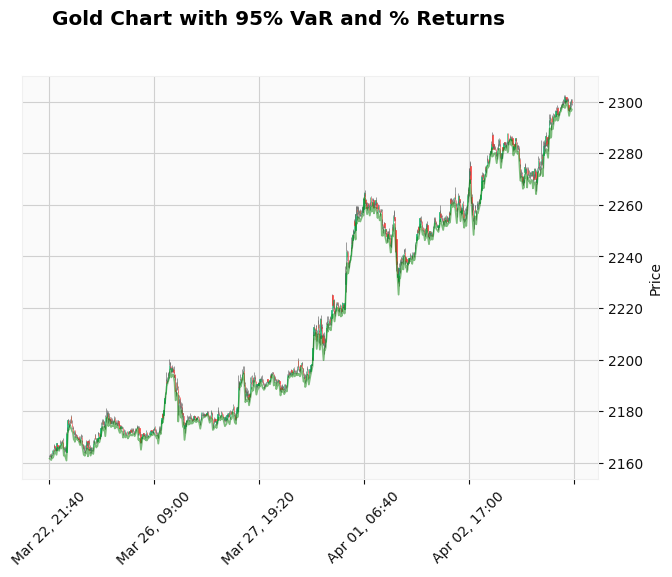

In [142]:
monte_ret_2.index = pd.to_datetime(monte_ret_2.time)
data = pd.DataFrame({
    'Open': monte_ret_2['open'],
    'High': monte_ret_2['high'],
    'Low': monte_ret_2['low'],
    'Close': monte_ret_2['close'],
}, index=monte_ret_2.index[1:])  # Exclude the first row to align with VaR and pct_returns

# Assuming 'pct_returns' is the column name containing the percentage returns data
pct_returns = checker['VaR_95_price']

# Plot the candlestick chart with the normalized VaR and percentage returns as additional plots
mpf.plot(data, type='candle', style='yahoo', addplot=[
    #mpf.make_addplot(var_95_mean, color='red', alpha=0.5),  # VaR as an additional plot
    mpf.make_addplot(pct_returns[:], color='green', alpha=0.5)  # Percentage returns as an additional plot
], title='Gold Chart with 95% VaR and % Returns',warn_too_much_data=10000)